- [데이터셋 출처](https://www.kaggle.com/c/digit-recognizer/overview)

In [120]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/digit-recognizer/train.csv')
display(df.head(), df.shape)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 785)

In [3]:
# 결측치 확인
display(df.isnull().sum().sum())
# 결측치 없음

0

In [4]:
# 이상치 뭘 봐야 이상치인지 모르겠음...

In [5]:
# training data set
x_data = df.drop(columns=['label']).values.reshape(-1,784)
t_data = df['label'].values

In [6]:
# label one hot encoding
sess = tf.Session()
t_data_onehot = sess.run(tf.one_hot(t_data, depth=10))

In [97]:
# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

In [184]:
# tensorflow 구현

# placeholder
X = tf.placeholder(shape=[None, 784], dtype=tf.float32)
T = tf.placeholder(shape=[None, 10], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([784, 10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# Hypothesis
logit = tf.matmul(X, W) + b
H = tf.nn.softmax(logit)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, 
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [191]:
# parameter
num_of_epoch = 1000
batch_size = 50
# 한번에 최대한 많은 양의 데이터를 넣는게 좋긴하다

# learning

# 학습용 함수
def run_train(sess, train_x, train_t):
    print('### 학습 시작 ###')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            
            _, loss_val = sess.run([train,loss], 
                                   feed_dict={X: batch_x, T: batch_t})
            
        if step % (num_of_epoch/10) == 0:
            print('loss : {}'.format(loss_val))
    print('### 학습 종료 ###')
    

# Accuracy 측정
predict = tf.argmax(H, 1)
correct = tf.equal(predict, tf.argmax(T, 1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

In [192]:
# learning with kfold
cv = 5
results = []

kf = KFold(n_splits=cv, shuffle=True)

for train_idx, val_idx in kf.split(x_data_norm):
    training_x = x_data_norm[train_idx]
    training_t = t_data_onehot[train_idx]
    
    val_x = x_data[val_idx]
    val_t = t_data_onehot[val_idx]
    
    run_train(sess, training_x, training_t)
    results.append(sess.run(accuracy, feed_dict={X: val_x, T: val_t}))

print('측정한 각각의 결과값 : {}'.format(results))
print('최종 k-fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))

### 학습 시작 ###
loss : 0.8288685083389282
loss : 0.1638454645872116
loss : 0.14893266558647156
loss : 0.14209452271461487
loss : 0.13790422677993774
loss : 0.135103240609169
loss : 0.13309013843536377
loss : 0.13154101371765137
loss : 0.13027337193489075
loss : 0.12918055057525635
### 학습 종료 ###
### 학습 시작 ###
loss : 1.4750046730041504
loss : 0.16495832800865173
loss : 0.13580544292926788
loss : 0.12741340696811676
loss : 0.12419857084751129
loss : 0.12278033047914505
loss : 0.12207546085119247
loss : 0.1216554343700409
loss : 0.12132856249809265
loss : 0.12100648880004883
### 학습 종료 ###
### 학습 시작 ###
loss : 1.4208835363388062
loss : 0.20157669484615326
loss : 0.15730291604995728
loss : 0.14588958024978638
loss : 0.14064070582389832
loss : 0.1376047283411026
loss : 0.13557669520378113
loss : 0.13403059542179108
loss : 0.1327064037322998
loss : 0.13147811591625214
### 학습 종료 ###
### 학습 시작 ###
loss : 1.961198329925537
loss : 0.205939382314682
loss : 0.18660181760787964
loss : 0.18124920129776


In [196]:
# test용 data
test_df = pd.read_csv('../data/digit-recognizer/test.csv')
test_data = test_df.values.reshape(-1,784)
test_data_norm = scaler.transform(test_data)

# Test Data Set을 이용하여 예측
result = sess.run(predict, feed_dict={X: test_data_norm})

# 예측결과를 test data에 결합
test_df.loc[:,'label'] = result

In [197]:
# 예측결과 비교 함수
def check_result(df):
    # 임의의 index 번호 생성
    tmp_num = np.random.randint(df.shape[0])
    # 임의의 index 번호에 대한 실제 데이터 그림
    plt.imshow(df.drop(columns=['label']).loc[tmp_num].values.reshape(28,28), 
               cmap='Greys')
    plt.title('Actual Value')
    plt.show()
    
    # 임의 index 번호에 대한 예측 결과
    print('Predict Value : {}'.format(df.loc[tmp_num,'label']))

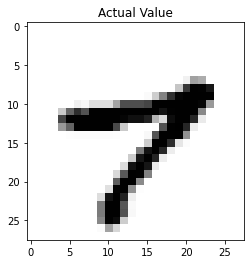

Predict Value : 7


In [202]:
check_result(test_df)

In [76]:
# 제출 파일 작성
submission = pd.read_csv('../data/digit-recognizer/sample_submission.csv')
submission['Label'] = result
submission.to_csv('../data/digit-recognizer/submission.csv', index=False)

In [206]:
# 임의의 사진으로 예측하기
# 이미지 url을 이용해 예측을 진행하고 예측결과와 실제결과 출력
def predict_img(url):
    data = mpimg.imread(url)
    x_data = data.reshape(-1, 784)
    x_data_norm = scaler.transform(x_data)
    
    result = sess.run(predict, feed_dict={X: x_data_norm})
    
    # 임의의 index 번호에 대한 실제 데이터 그림
    plt.imshow(x_data.reshape(28,28))
    plt.title('Actual Value')
    plt.show()
    
    # 임의 index 번호에 대한 예측 결과
    print('Predict Value : {}'.format(result))

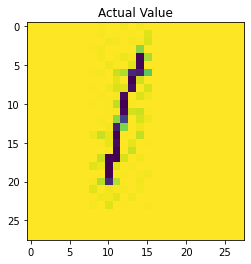

Predict Value : [8]


In [207]:
# 문제 어떻게 흑백 사진을 만들것인가?
sample_url = '../data/digit-recognizer/sample.jpg'
predict_img(sample_url)

(28, 28, 3)


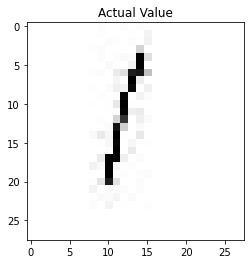

In [208]:
# 데이터 문제 형태 문제

data = mpimg.imread('../data/digit-recognizer/sample.jpg')
print(data.shape)
plt.imshow(data, cmap='Greys')
plt.title('Actual Value')
plt.show()